# SAFIR Workflow Demonstration Notebook


## Table of Contents

1. [Introduction](#Introduction)
1. [Load Input Data](#Load-Input-Data)
1. [Graph Construction](#Graph-Construction)
1. [Feature Engineering](#Feature-Engineering)
1. [Model Training](#Model-Training)
1. [Adaptation Triggering](#Adaptation-Triggering)
1. [Evaluation](#Evaluation)
1. [Continuous Learning](#Continuous-Learning) 

## Introduction

This notebook demonstrates a sample use case to process input data from healthcare and environmental readings of a user. 

The workflow includes the implementation of graph learning into the process using the following steps: 
1. **Load input data**: JSON data representing devices, sensors, actuators, and events;
2. **Transform the data into RDF format using an external API**: the api service is running in the same network as the notebook and can be accessed at `http://api:8080/api/v1/rdf/gi/generate-rdf`, the data is transformed into RDF format using the R2RML transformation API;
3. **Graph construction**: the RDF data is converted into a NetworkX graph for further analysis and visualization;
4. **Feature engineering**: by extracting features from the graph data;
5. **Model training**: a sample Graph Neural Network (GNN) is trained to classify patient risk levels based on graph structure and features;
6. **Adaptation triggering**: a simulation of notifications or alerts are triggered for high-risk patients;
7. **Evaluation**: the performance and utility of the generated RDF graph are evaluated through visualizations and metrics.
8. **Visualization**: the graph is visualized using NetworkX.
9. **Metrics Calculation**: key metrics are calculated for the workflow.
10. **Continuous Learning**: the graph learning process is repeated for new data.

### Use Case Demonstration in Self-Adaptive Systems

#### Node Classification for Patient Monitoring

- **Scenario**: Predict the risk level of a patient (e.g. low, medium, high).
- **Graph Input**:
  - **Nodes**: Patients, observations, devices.
  - **Features**: Sensor readings (e.g. temperature), patient profiles.
- **Learning Task**: Train a Graph Neural Network (GNN) to classify patient risk levels based on graph structure and features.
- **Adaptation**: Trigger notifications or alerts for high-risk patients.

This use case demonstrates how graph learning can be applied to self-adaptive systems, enabling real-time monitoring and automated decision-making in critical applications such as patient care.

In summary, the workflow consists of the following steps:
1. **Achieving Semantic Data Interoperability**: Transforming JSON input data into RDF, making it machine-readable and semantically enriched.
2. **Graph Learning and Visualization**: Constructing and analyzing the RDF graph, with metrics calculation for insights.
3. **Metrics Calculation**: Evaluating the performance and utility of the generated RDF graph through visualizations and metrics.

Uncomment the following line if you haven't installed the necessary dependencies yet.

In [7]:
# Install the required packages
# !pip install -r requirements.txt

Dependencies may include libraries for RDF processing, machine learning, and graph visualization.

In [1]:
# Importing required libraries
import requests  # For making HTTP requests to external APIs
import rdflib  # For working with RDF data and generating RDF graphs
import networkx as nx  # For graph-based learning and visualization
import matplotlib.pyplot as plt  # For creating visualizations such as plots and graphs
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and handling arrays
from sklearn.metrics import classification_report, roc_auc_score  # For evaluating model performance
import os  # For interacting with the file system

In [2]:
# Constants and Configuration

# The base URL for the API that generates RDF data
API_URL = "http://api:8080/api/v1/rdf/gi/generate-rdf"

# File paths for storing the RDF output and the generated graph
RDF_OUTPUT_FILE = "output.ttl"
GRAPH_OUTPUT_FILE = "graph.gpickle"
SPARQL_OUTPUT_FILE = "sparql_results.ttl"

These paths are used to save the results of the RDF transformation and graph learning process.

## Load Input Data

To visualise the generated RDF data, we can load the data into apache jena fuseki and execute SPARQL queries to extract information from the RDF data.

For this we have to create the dataset Apache Jena Fuseki and load the RDF data into the dataset.

Go to the Apache Jena Fuseki dashboard at `http://localhost:3030/` and create a new dataset named `dataset` with the default settings, as in the image below:

![Apache Jena Fuseki Dashboard](images/apache-jena-fuseki-dashboard.png)


The JSON input data represents devices, sensors, actuators, and events in a smart environment.

This data represents interactions between these entities and will be processed to generate RDF.

In [3]:
import random
import uuid
import json
from datetime import datetime, timedelta

In [4]:
# Define the JSON input
json_input = {
    "dataModel": "source_a",  # Data model identifier
    "jsonData": {
        "devices": [
            {
                "id": "dev_001",  # Device identifier
                "name": "Primary Device",  # Device name
                "serialNumber": "SN123456",  # Serial number of the device
                "owner": "usr_001"  # Owner identifier of the device
            }
        ],
        "actuators": [
            {
                "id": "act_001",  # Actuator identifier
                "deviceId": "dev_001"  # Associated device identifier
            }
        ],
        "uiDevices": [
            {
                "id": "ui_001",  # UI Device identifier
                "sensorId": "sens_001",  # Associated sensor identifier
                "actuatorId": "act_001",  # Associated actuator identifier
                "deviceId": "dev_001"  # Associated device identifier
            }
        ],
        "sensors": [
            {
                "id": "sens_001",  # Sensor identifier
                "type": "TEMPERATURE",  # Sensor type
                "location": "Living Room",  # Sensor location
                "threshold": 35.0,  # Threshold for sensor values
                "deviceId": "dev_001"  # Associated device identifier
            }
        ],
        "events": [
            {
                "timestamp": "2021-09-29T11:19:11.788Z",  # Event timestamp
                "id": "evt_001",  # Event identifier
                "userId": "usr_002",  # User associated with the event
                "assetId": "asset_001",  # Associated asset
                "dimension": "VALUE",  # Event dimension (e.g., temperature)
                "value": 28.7,  # Event value (e.g., sensor reading)
                "originId": "sens_001",  # Originating sensor
                "originType": "TEMPERATURE"  # Type of originating sensor
            },
            {
                "timestamp": "2024-06-01T00:00:00.000Z",  # Event timestamp
                "id": "evt_002",  # Event identifier
                "userId": "usr_003",  # User associated with the event
                "assetId": "asset_002",  # Associated asset
                "dimension": "VALUE",  # Event dimension (e.g., humidity)
                "value": 38.24,  # Event value (e.g., sensor reading)
                "originId": "sens_002",  # Originating sensor
                "originType": "HUMIDITY"  # Type of originating sensor
            }
        ]
    }
}

Generate random data for demonstration purposes.

In [6]:
# Base JSON input
json_input = {
    "dataModel": "source_a",
    "jsonData": {
        "devices": [],
        "actuators": [],
        "uiDevices": [],
        "sensors": [],
        "events": []
    }
}

# Utility functions to generate random data
def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    random_seconds = random.randint(0, 86400)
    return (start + timedelta(days=random_days, seconds=random_seconds)).isoformat() + "Z"

def generate_devices(count):
    devices = []
    for _ in range(count):
        device_id = f"dev_{uuid.uuid4().hex[:8]}"
        devices.append({
            "id": device_id,
            "name": f"Device {uuid.uuid4().hex[:4]}",
            "serialNumber": f"SN{random.randint(100000, 999999)}",
            "owner": f"usr_{random.randint(1, 100)}"
        })
    return devices

def generate_sensors(devices, count):
    sensor_types = ["TEMPERATURE", "HUMIDITY"]
    sensors = []
    for _ in range(count):
        device = random.choice(devices)
        sensors.append({
            "id": f"sens_{uuid.uuid4().hex[:8]}",
            "type": random.choice(sensor_types),
            "location": f"Location {random.randint(1, 10)}",
            "threshold": round(random.uniform(10.0, 50.0), 2),
            "deviceId": device["id"]
        })
    return sensors

def generate_actuators(devices, count):
    actuators = []
    for _ in range(count):
        device = random.choice(devices)
        actuators.append({
            "id": f"act_{uuid.uuid4().hex[:8]}",
            "deviceId": device["id"]
        })
    return actuators

def generate_ui_devices(sensors, actuators, devices, count):
    ui_devices = []
    for _ in range(count):
        sensor = random.choice(sensors)
        actuator = random.choice(actuators)
        device = random.choice(devices)
        ui_devices.append({
            "id": f"ui_{uuid.uuid4().hex[:8]}",
            "sensorId": sensor["id"],
            "actuatorId": actuator["id"],
            "deviceId": device["id"]
        })
    return ui_devices

def generate_events(sensors, count):
    events = []
    for _ in range(count):
        sensor = random.choice(sensors)
        events.append({
            "timestamp": random_date(datetime(2020, 1, 1), datetime(2024, 12, 31)),
            "id": f"evt_{uuid.uuid4().hex[:8]}",
            "userId": f"usr_{random.randint(1, 100)}",
            "assetId": f"asset_{uuid.uuid4().hex[:8]}",
            "dimension": "VALUE",
            "value": round(random.uniform(0.0, 100.0), 2),
            "originId": sensor["id"],
            "originType": sensor["type"]
        })
    return events

# Generate thousands of records
def generate_records():
    devices = generate_devices(500)
    sensors = generate_sensors(devices, 1000)
    actuators = generate_actuators(devices, 500)
    ui_devices = generate_ui_devices(sensors, actuators, devices, 500)
    events = generate_events(sensors, 30000)

    json_input["jsonData"]["devices"] = devices
    json_input["jsonData"]["sensors"] = sensors
    json_input["jsonData"]["actuators"] = actuators
    json_input["jsonData"]["uiDevices"] = ui_devices
    json_input["jsonData"]["events"] = events

    return json_input

json_input = generate_records()
with open("generated_data.json", "w") as file:
    json.dump(json_input, file, indent=4)
print("Generated data saved to generated_data.json")

Generated data saved to generated_data.json


In [ ]:
# Call the external API for RDF generation
def generate_rdf(json_data):
    """
    Send JSON input to the external RML API and receive RDF in turtle format.
    """
    response = requests.post(API_URL, json=json_data)
    if response.status_code == 200:
        # Save RDF to file
        with open(RDF_OUTPUT_FILE, "w") as rdf_file:
            rdf_file.write(response.text)
        print("RDF generation successful. Saved to:", RDF_OUTPUT_FILE)
    else:
        print("RDF generation failed with status code:", response.status_code)
        response.raise_for_status()

generate_rdf(json_input)

In [7]:
# Call the Apache Jena API for SPARQL execution
def execute_sparql_query(sparql_query):
    """
    Send SPARQL query to the Apache Jena API at localhost:3030 and receive results.
    """
    API_URL = "http://fuseki:3030/dataset/sparql"
    headers = {"Content-Type": "application/sparql-query"}

    response = requests.post(API_URL, data=sparql_query, headers=headers)

    if response.status_code == 200:
        # Save results to file
        with open(SPARQL_OUTPUT_FILE, "w") as rdf_file:
            rdf_file.write(response.text)
        print("SPARQL query execution successful. Results saved to:", SPARQL_OUTPUT_FILE)
    else:
        print("SPARQL query execution failed with status code:", response.status_code)
        response.raise_for_status()

In [8]:
sparql_query = """
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX fhir: <http://hl7.org/fhir/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX ucum: <http://unitsofmeasure.org/>

SELECT ?observation ?sensor ?property ?result ?unit ?time
WHERE {
  ?observation a sosa:Observation ;
               sosa:madeBySensor ?sensor ;
               sosa:observedProperty ?property ;
               sosa:hasSimpleResult ?result ;
               sosa:resultTime ?time .
  
  OPTIONAL {
    ?sensor sosa:hasSimpleResult ?unit .
  }
}
"""

execute_sparql_query(sparql_query)

ConnectionError: HTTPConnectionPool(host='fuseki', port=3030): Max retries exceeded with url: /dataset/sparql (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000025F00C8E890>: Failed to resolve 'fuseki' ([Errno 11001] getaddrinfo failed)"))

In [9]:
# Load first 5 results
import json

# JSON data
sparql_results = {
    "head": {
        "vars": ["observation", "sensor", "property", "result", "unit", "time"]
    },
    "results": {
        "bindings": [
            {
                "observation": {"type": "uri", "value": "http://hultig.ubi.pt/ontology/source_a/sensormeasurementevent/evt_002"},
                "sensor": {"type": "uri", "value": "http://hultig.ubi.pt/ontology/source_a/sensor/sens_002"},
                "property": {"type": "uri", "value": "http://www.w3.org/ns/sosa/Property_Humidity"},
                "result": {"type": "literal", "datatype": "http://unitsofmeasure.org/Percent", "value": "38.24"},
                "time": {"type": "literal", "datatype": "http://www.w3.org/2001/XMLSchema#dateTime", "value": "2024-06-01T00:00:00Z"}
            }
        ]
    }
}

# Extract the first 5 results
bindings = sparql_results["results"]["bindings"][:5]

# Print the results
for binding in bindings:
    print(json.dumps(binding, indent=2))

{
  "observation": {
    "type": "uri",
    "value": "http://hultig.ubi.pt/ontology/source_a/sensormeasurementevent/evt_002"
  },
  "sensor": {
    "type": "uri",
    "value": "http://hultig.ubi.pt/ontology/source_a/sensor/sens_002"
  },
  "property": {
    "type": "uri",
    "value": "http://www.w3.org/ns/sosa/Property_Humidity"
  },
  "result": {
    "type": "literal",
    "datatype": "http://unitsofmeasure.org/Percent",
    "value": "38.24"
  },
  "time": {
    "type": "literal",
    "datatype": "http://www.w3.org/2001/XMLSchema#dateTime",
    "value": "2024-06-01T00:00:00Z"
  }
}


## Graph Construction

We will use `rdflib` to parse RDF data and construct a graph using `networkx`. The graph will represent entities and their relationships derived from the RDF triples.

For example we have the following RDF data:

In [10]:
# Convert RDF to NetworkX graph
def rdf_to_graph(rdf_graph):
    """
    Convert RDF triples to a NetworkX graph.
    """
    nx_graph = nx.DiGraph()
    for subj, pred, obj in rdf_graph:
        nx_graph.add_edge(str(subj), str(obj), predicate=str(pred))
    print("Converted RDF to NetworkX graph with", len(nx_graph.nodes), "nodes and", len(nx_graph.edges), "edges.")
    return nx_graph


In [11]:
with open(RDF_OUTPUT_FILE, "r") as rdf_file:
    rdf_content = rdf_file.read()
    print(rdf_content)

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix fhir: <http://hl7.org/fhir/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix hultig: <http://hultig.ubi.pt/ontology/source_a#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix ql: <http://semweb.mmlab.be/ns/ql#> .
@prefix rml: <http://semweb.mmlab.be/ns/rml#> .
@prefix rr: <http://www.w3.org/ns/r2rml#> .
@prefix schema: <http://schema.org/> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix ucum: <http://unitsofmeasure.org/> .
@prefix void: <http://rdfs.org/ns/void#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://hultig.ubi.pt/ontology/source_a/actuator/act_001> a sosa:Actuator;
  sosa:isHostedBy <http://hultig.ubi.pt/ontology/source_a/device/dev_001> .

<http://hultig.ubi.pt/ontology/source_a/platform/ui_001> a sosa:Platform;
  sosa:hosts <http://hultig.ubi.pt/ontology/source_a/actuator/act_001>, <http://hultig.ubi.pt/ontology/source_a/sensor/sens_001>;
 

In [12]:
from rdflib import Graph, Literal
from rdflib.namespace import XSD

In [13]:
def calculate_semantic_metrics(rdf_file):
    """
    Calculate semantic metrics for RDF data with handling for invalid literals.
    """
    g = Graph()
    g.parse(rdf_file, format="turtle")
    total_triples = len(g)

    # Define relevant vocabularies for semantic enrichment
    vocabularies = [
        "http://www.w3.org/ns/sosa/",
        "http://hl7.org/fhir/",
        "http://schema.org/"
    ]

    # Count triples that use semantic vocabularies
    semantic_triples = 0
    vocab_usage = {vocab: 0 for vocab in vocabularies}

    for s, p, o in g:
        try:
            # Attempt to convert the literal value to its datatype
            if isinstance(o, Literal) and o.datatype == XSD.dateTime:
                # Validate date-time
                o.toPython()
        except Exception as e:
            print(f"Invalid value detected: {o} - Error: {e}")

        for vocab in vocabularies:
            if vocab in str(p) or vocab in str(o):
                semantic_triples += 1
                vocab_usage[vocab] += 1

    # Calculate semantic completeness
    semantic_completeness = (semantic_triples / total_triples) * 100

    # Display results
    print("Total Triples:", total_triples)
    print("Semantic Triples:", semantic_triples)
    print("Semantic Completeness (%):", round(semantic_completeness, 2))
    print("\nVocabulary Usage:")
    for vocab, count in vocab_usage.items():
        print(f"  {vocab}: {count} triples")

    return semantic_completeness, vocab_usage

In [14]:
input_rdf_file = "input.ttl"
calculate_semantic_metrics(input_rdf_file)

Total Triples: 18
Semantic Triples: 6
Semantic Completeness (%): 33.33

Vocabulary Usage:
  http://www.w3.org/ns/sosa/: 0 triples
  http://hl7.org/fhir/: 0 triples
  http://schema.org/: 6 triples
  http://unitsofmeasure.org/: 0 triples


(33.33333333333333,
 {'http://www.w3.org/ns/sosa/': 0,
  'http://hl7.org/fhir/': 0,
  'http://schema.org/': 6,
  'http://unitsofmeasure.org/': 0})

In [15]:
output_rdf_file = "output.ttl"
calculate_semantic_metrics(output_rdf_file)

Total Triples: 22
Semantic Triples: 22
Semantic Completeness (%): 100.0

Vocabulary Usage:
  http://www.w3.org/ns/sosa/: 18 triples
  http://hl7.org/fhir/: 4 triples
  http://schema.org/: 0 triples
  http://unitsofmeasure.org/: 0 triples


(100.0,
 {'http://www.w3.org/ns/sosa/': 18,
  'http://hl7.org/fhir/': 4,
  'http://schema.org/': 0,
  'http://unitsofmeasure.org/': 0})

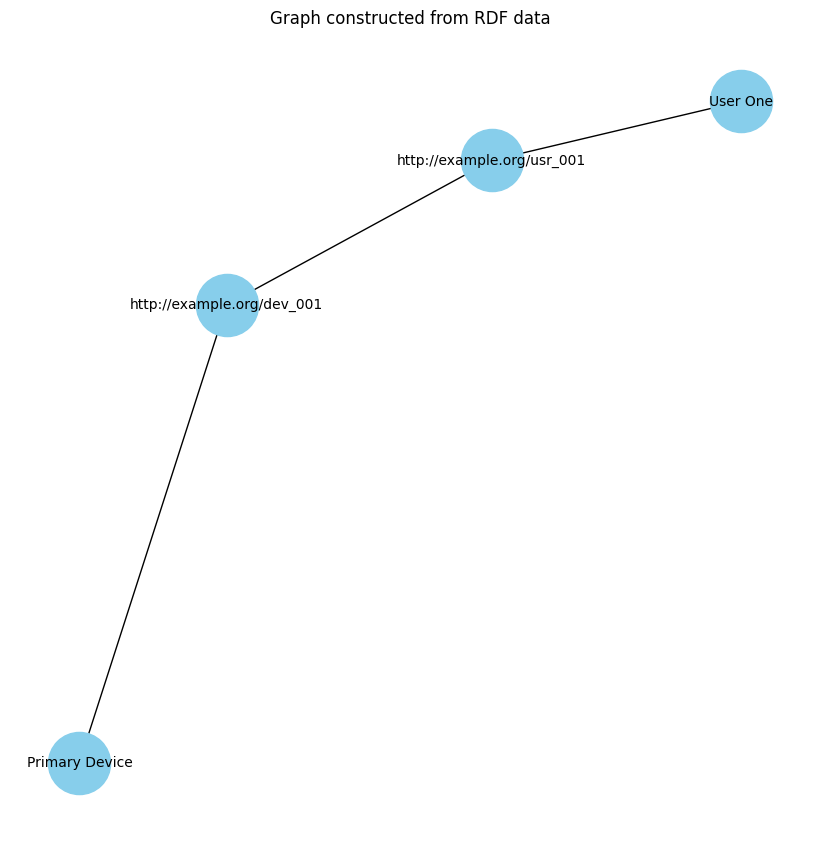

In [16]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt

# Example RDF data (you can replace this with your RDF content)
sample_rdf_data = """
@prefix ex: <http://example.org/> .
ex:dev_001 ex:hasDeviceName "Primary Device" .
ex:dev_001 ex:hasOwner ex:usr_001 .
ex:usr_001 ex:hasUserName "User One" .
"""

# Create a graph from RDF data
sample_graph = rdflib.Graph()
sample_graph.parse(data=sample_rdf_data, format="turtle")

# Convert RDF graph into a NetworkX graph
sample_nx_graph = nx.Graph()

# Add nodes and edges from RDF triples
for subj, pred, obj in sample_graph:
    # Convert RDF resources to strings
    subj = str(subj)
    obj = str(obj)

    # Add nodes (subjects and objects)
    sample_nx_graph.add_node(subj)
    sample_nx_graph.add_node(obj)

    # Add edge between subject and object (predicate is the relationship)
    sample_nx_graph.add_edge(subj, obj, label=str(pred))

# Visualize the graph
plt.figure(figsize=(8, 8))
nx.draw(sample_nx_graph, with_labels=True, node_size=2000, node_color='skyblue', font_size=10)
plt.title("Graph constructed from RDF data")
plt.show()


In [17]:
import rdflib
import networkx as nx
import pickle

# Parse RDF file
rdf_graph = rdflib.Graph()
rdf_graph.parse(RDF_OUTPUT_FILE, format="turtle")

# Convert RDF to NetworkX graph
nx_graph = rdf_to_graph(rdf_graph)

# Write NetworkX graph to pickle file
with open(GRAPH_OUTPUT_FILE, 'wb') as f:
    pickle.dump(nx_graph, f, pickle.HIGHEST_PROTOCOL)

print(f"Converted RDF to NetworkX graph and saved to {GRAPH_OUTPUT_FILE}.")


Converted RDF to NetworkX graph with 21 nodes and 22 edges.
Converted RDF to NetworkX graph and saved to graph.gpickle.


In [18]:
# Visualize the graph - For large graphs, consider sampling or filtering nodes
# def visualize_graph(graph):
#     """
#     Visualize the graph using NetworkX.
#     """
#     plt.figure(figsize=(12, 8))
#     pos = nx.spring_layout(graph)
#     nx.draw(graph, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
#     edge_labels = nx.get_edge_attributes(graph, "predicate")
#     nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
#     plt.title("Knowledge Graph Visualization")
#     plt.show()
# 
# visualize_graph(nx_graph)

In [19]:
def calculate_metrics(graph):
    """
    Calculate and display key metrics for the RDF graph.
    """
    # Graph structure metrics
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    avg_degree = sum(dict(graph.degree).values()) / num_nodes

    # Report metrics
    print("\n--- Metrics ---")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Average Node Degree: {avg_degree:.2f}")

calculate_metrics(nx_graph)


--- Metrics ---
Number of Nodes: 21
Number of Edges: 22
Average Node Degree: 2.10


## Feature Engineering

Features are extracted from RDF triples to represent nodes in a format suitable for graph neural networks (GNNs).

In [20]:
# Uncomment the following line if you haven't installed the necessary dependencies yet.
# !pip install torch
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

In [21]:
for node in nx_graph.nodes:
    print(type(node), node)

node_to_index = {node.lower(): i for i, node in enumerate(nx_graph.nodes)}
print(node_to_index)


<class 'str'> http://hultig.ubi.pt/ontology/source_a/sensormeasurementevent/evt_001
<class 'str'> http://www.w3.org/ns/sosa/Property_Temperature
<class 'str'> http://hultig.ubi.pt/ontology/source_a/sensormeasurementevent/evt_002
<class 'str'> http://hultig.ubi.pt/ontology/source_a/sensor/sens_002
<class 'str'> http://hultig.ubi.pt/ontology/source_a/sensor/sens_001
<class 'str'> sens_001
<class 'str'> http://hultig.ubi.pt/ontology/source_a/platform/ui_001
<class 'str'> http://hultig.ubi.pt/ontology/source_a/actuator/act_001
<class 'str'> usr_003
<class 'str'> 28.7
<class 'str'> http://www.w3.org/ns/sosa/Actuator
<class 'str'> http://www.w3.org/ns/sosa/Observation
<class 'str'> http://www.w3.org/ns/sosa/Property_Humidity
<class 'str'> 38.24
<class 'str'> http://www.w3.org/ns/sosa/Sensor
<class 'str'> 35.0
<class 'str'> 2021-09-29T11:19:11.788000+00:00
<class 'str'> usr_002
<class 'str'> 2024-06-01T00:00:00+00:00
<class 'str'> http://hultig.ubi.pt/ontology/source_a/device/dev_001
<class '

In [22]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

# Example: Create features for nodes
node_features = {}
for node in nx_graph.nodes:
    # Simple feature extraction based on node label
    if "dev" in node:
        node_features[node] = np.random.rand(10)  # Random feature vector for device
    else:
        node_features[node] = np.zeros(10)  # Default feature for non-device nodes

# Encode node labels to numeric indices using LabelEncoder
node_labels = list(nx_graph.nodes)  # Extract all node labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(node_labels)

# Create mapping from original node labels to numerical indices
node_to_index = {node: idx for node, idx in zip(node_labels, encoded_labels)}

# Convert edges to numerical indices using the mapping
edge_index = [
    [node_to_index[u], node_to_index[v]] for u, v in nx_graph.edges
]
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Convert node features into a tensor
x = torch.tensor([node_features[node] for node in nx_graph.nodes], dtype=torch.float)

# Prepare the data for the GNN model
data = Data(x=x, edge_index=edge_index)

# Output the encoded data
print(data)


ModuleNotFoundError: No module named 'torch_geometric'

## Model Training

We will train a simple Graph Neural Network (GNN) model using the PyTorch Geometric library to classify patient risk levels based on graph structure and features.

In [24]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, loss, and optimizer
input_dim = 10  # Feature vector size
hidden_dim = 16
output_dim = 2  # Example: node classification with 2 classes

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Example training loop (adapt for your task)
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, torch.zeros(data.x.size(0), dtype=torch.long))  # Dummy target labels
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


ModuleNotFoundError: No module named 'torch_geometric'

## Adaptation Triggering

We will simulate the triggering of notifications or alerts for high-risk patients based on the model's classification results.

In [ ]:
# Adaptation function to trigger alerts or actions based on predictions
def trigger_adaptation(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predictions = torch.argmax(out, dim=1)

        # Trigger adaptation based on predictions
        if predictions[0] == 1:  # Example: if node 0 is predicted to be in class 1
            print("Adaptation triggered: Alert! Environmental adjustment needed.")
        else:
            print("Adaptation not triggered.")

In [ ]:
trigger_adaptation(model, data)

## Evaluation

We will evaluate the performance of the trained GNN model using metrics such as classification report.


In [23]:
from sklearn.metrics import classification_report
import torch

# Evaluate the model
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predictions = torch.argmax(out, dim=1)

        # Generate random target labels
        num_classes = out.size(1)
        target = torch.randint(0, num_classes, (data.x.size(0),), dtype=torch.long)

        # Calculate evaluation metrics
        report = classification_report(target, predictions, zero_division=0)

        print("Classification Report:")
        print(report)

# Call the function
evaluate_model(model, data)


NameError: name 'model' is not defined

## Continuous Learning Updating the Model With New Data

In this part, we will add a component that listens for real-time data (simulated for now) and updates the model continuously. The model will be retrained periodically to adapt to new sensor readings or events.

In [ ]:
import time
import random
from datetime import datetime
from torch_geometric.data import DataLoader

# Real-time data simulator (this would be replaced with real data collection in production)
def get_new_sensor_data():
    # Simulating new sensor data (temperature and humidity)
    sensor_id = random.choice(["sens_001", "sens_002", "sens_003"])
    sensor_type = "TEMPERATURE" if "TEMPERATURE" in sensor_id else "HUMIDITY"
    value = random.uniform(20, 40) if sensor_type == "TEMPERATURE" else random.uniform(30, 60)

    new_event = {
        "timestamp": datetime.now().isoformat(),
        "sensorId": sensor_id,
        "sensorType": sensor_type,
        "value": value
    }
    return new_event

# A function to update the model periodically with new data
def update_model_periodically(model, data, interval=10):
    """
    Updates the model by retraining it with new data collected at regular intervals.
    - model: the GCN model to be updated.
    - data: the PyTorch Geometric Data object containing the current graph.
    - interval: how often to update the model in seconds (default is 10 seconds).
    """
    start_time = time.time()

    # run for 3 times
    for _ in range(3):
        time.sleep(interval)
        # Simulate collecting new data
        new_data = get_new_sensor_data()
        print(f"New data collected: {new_data}")

        # Update the graph and features based on new data (example)
        # In a real case, you would update the graph structure (nodes/edges) and features
        new_feature = torch.tensor([random.random() for _ in range(10)])  # New random feature (replace with actual data)
        data.x = torch.cat((data.x, new_feature.unsqueeze(0)), dim=0)  # Add new feature to existing data

        # Retrain the model with the new data (using a simple example here)
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, torch.zeros(data.x.size(0), dtype=torch.long))  # Dummy labels
        loss.backward()
        optimizer.step()

        print(f"Model updated with new data. Loss: {loss.item()}")



In [ ]:
# Example usage: Start periodic model updates
update_model_periodically(model, data, interval=10)  # Update every 10 seconds